In [1]:
import glob
import numpy as np
from pathlib import Path
from math import floor
import timeit
import os
import random
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import auc, precision_recall_curve                                                  

In [2]:
# Define data directories
DCA_ER_dir = '/data/cresswellclayec/DCA_ER' # Set DCA_ER directory
biowulf_dir = '%s/biowulf_full' % DCA_ER_dir
processed_data_dir = "%s/protein_data/data_processing_output/" % biowulf_dir

pdb_path = "/data/cresswellclayec/DCA_ER/biowulf_full/protein_data/metrics"
data_path = "/data/cresswellclayec/DCA_ER/biowulf_full/protein_data/data_processing_output"
metric_dir = "/data/cresswellclayec/DCA_ER/biowulf_full/protein_data/metrics"


ER_tprs = []
ER_fprs = []
PMF_tprs = []
PMF_fprs = []
PLM_tprs = []
PLM_fprs = []
MF_tprs = []
MF_fprs = []

ks_compares = []
mc = []
ER_bootstrap_aucs = []

MSA_sizes = []
n_cols = []
n_seqs = []

file_end = '_uni.npy'
file_end = '_uni_ld5.npy'
file_end = '.npy'

bootstrapping = False
if bootstrapping:
    # Get list of files from completed auc-bootstrap files
    boot_auc_files = list(Path(pdb_path).rglob("*bootstrap_aucs.npy"))
    boot_auc_files_str = [str(os.path.basename(path)) for path in boot_auc_files]
    pfam_ids = [tp_str[:7] for tp_str in boot_auc_files_str] 
    pdb_ids = [tp_str[8:12] for tp_str in boot_auc_files_str] 
else:
    # Get list of files from completed TP files
    ks_files = list(Path(pdb_path).rglob("*method_comparison.pkl"))
    ks_files_str = [str(os.path.basename(path)) for path in ks_files]
    pfam_ids = [ks_str[5:12] for ks_str in ks_files_str] 
    pdb_ids = [ks_str[:4] for ks_str in ks_files_str] 
    
effective_seqs = []
print(pfam_ids[:10])
for i, pdb_id in enumerate(pdb_ids):
    pfam_id = pfam_ids[i]
    try:
        ER_fp_file = "%s/%s_%s_ER_fp%s" % (pdb_path, pdb_id, pfam_id, file_end)
        ER_tp_file = "%s/%s_%s_ER_tp%s" % (pdb_path, pdb_id, pfam_id, file_end)
        ER_fp = np.load(ER_fp_file)
        ER_tp = np.load(ER_tp_file)

        PMF_fp_file = "%s/%s_%s_PMF_fp%s" % (pdb_path, pdb_id, pfam_id, file_end)
        PMF_tp_file = "%s/%s_%s_PMF_tp%s" % (pdb_path, pdb_id, pfam_id, file_end)
        PMF_fp = np.load(PMF_fp_file)
        PMF_tp = np.load(PMF_tp_file)

        PLM_fp_file = "%s/%s_%s_PLM_fp%s" % (pdb_path, pdb_id, pfam_id, file_end)
        PLM_tp_file = "%s/%s_%s_PLM_tp%s" % (pdb_path, pdb_id, pfam_id, file_end)
        PLM_fp = np.load(PLM_fp_file)
        PLM_tp = np.load(PLM_tp_file)

    #     MF_fp_file = "%s/%s_%s_MF_fp%s" % (pdb_path, pdb_id, pfam_id, file_end)
    #     MF_tp_file = "%s/%s_%s_MF_tp%s" % (pdb_path, pdb_id, pfam_id, file_end)
    #     MF_fp = np.load(MF_fp_file)
    #     MF_tp = np.load(MF_tp_file)   

        if bootstrapping:
            ER_bootstrap_file = "%s/%s_%s_bootstrap_aucs.npy" % (pdb_path, pfam_id, pdb_id)
            ER_bootstrap = np.load(ER_bootstrap_file)

        MSA_file = "%s/%s_%s_preproc_msa.npy" % (data_path, pfam_id, pdb_id)
        MSA = np.load(MSA_file)

        pfam_dimensions_file = "%s%s_%s_pfam_dimensions.npy" % (processed_data_dir, pdb_id, pfam_id)
        pfam_dimensions = np.load(pfam_dimensions_file)

    #     ks_file = "%s/%s_%s_ks.pkl" % (pdb_path, pdb_id, pfam_id)
    #     with open(ks_file, "rb") as f:
    #        ks = pickle.load(f)
    #     f.close()
    #     print(ks)

        compare_file = "%s/%s_%s_method_comparison.pkl" % (pdb_path, pdb_id, pfam_id)
        with open(compare_file, "rb") as f:
            comparison = pickle.load(f)
        f.close()

    except(FileNotFoundError):
        continue
    PMF_fprs.append(PMF_fp)
    PMF_tprs.append(PMF_tp)
#     MF_fprs.append(MF_fp)
#     MF_tprs.append(MF_tp)
    ER_fprs.append(ER_fp)
    ER_tprs.append(ER_tp)
    PLM_fprs.append(PLM_fp)
    PLM_tprs.append(PLM_tp)

#     ks_compares.append(ks)
    mc.append(comparison)
    if bootstrapping:
        ER_bootstrap_aucs.append(ER_bootstrap)

    MSA_sizes.append(MSA.shape)
    if len(pfam_dimensions)==7:
        [n_col, n_seq, m_eff, ct_ER, ct_MF, ct_PMF, ct_PLM] = pfam_dimensions
    elif len(pfam_dimensions)==6: # new pfam_dimensions created in run_method_comparison. we dont need MF..
        [n_col, n_seq, m_eff, ct_ER, ct_PMF, ct_PLM] = pfam_dimensions
    elif len(pfam_dimensions)==3:
        [n_col, n_seq, m_eff] = pfam_dimensions
    effective_seqs.append(m_eff)
    n_cols.append(n_col)
    n_seqs.append(n_seq)

print(len(pfam_ids), ' Pfams plotted')

['PF02670', 'PF01179', 'PF00089', 'PF00144', 'PF00019', 'PF00261', 'PF05336', 'PF00180', 'PF07724', 'PF00959']
47022  Pfams plotted


# Plotting all ROC curves

46827
46827
46827
[0.         0.01616665 0.01616665 ... 0.99974053 0.99974128 0.99974179]
[0.00000000e+00 4.90234528e-06 5.91103887e-06 ... 9.99901555e-01
 9.99912296e-01 1.00000000e+00]


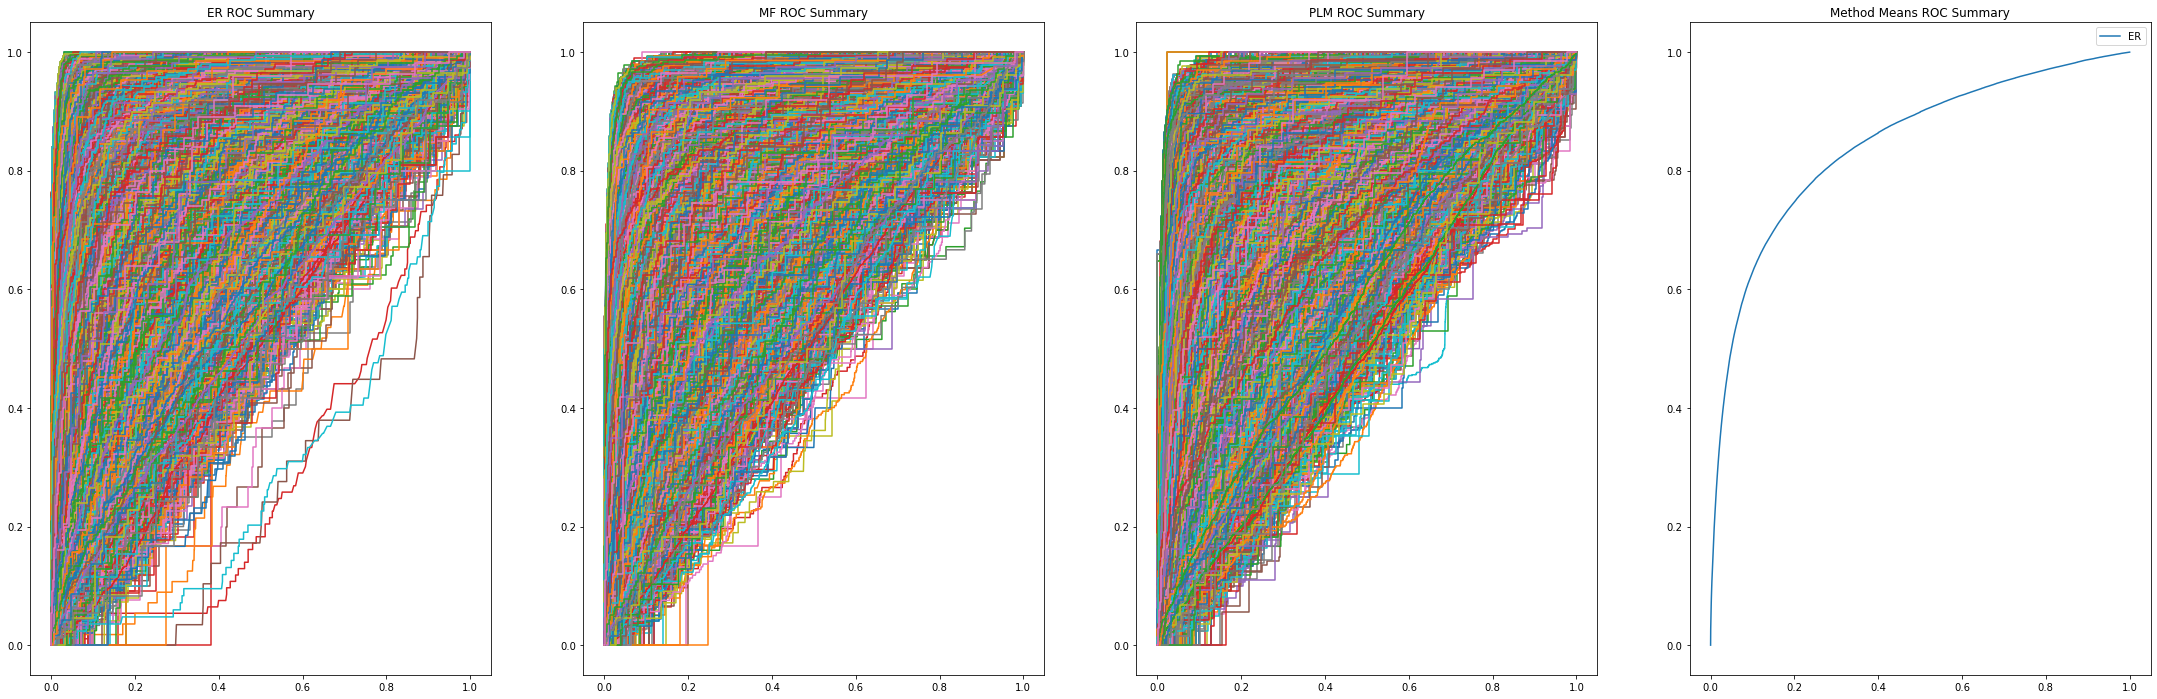

In [3]:
# method_tprs = [ER_tprs, PMF_tprs, PLM_tprs, MF_tprs]
# method_fprs = [ER_fprs, PMF_fprs, PLM_fprs, MF_fprs]
# method_label = ['ER', 'PMF', 'PLM', 'MF']
method_tprs = [ER_tprs, PMF_tprs, PLM_tprs]
method_fprs = [ER_fprs, PMF_fprs, PLM_fprs]
for tpr in method_tprs:
    print(len(tpr))
method_ids = ['ER', 'PMF', 'PLM']
method_label =  ['ER', 'MF', 'PLM']
method_color = 'brg'
plt.figure(figsize=(38.0,12))
method_aucs = []
for i, method_tpr_data in enumerate(method_tprs):
    method_fpr_data = method_fprs[i]
    method_aucs.append([])
    # Initalize ROC-curve tile
    plt.subplot2grid((1,4),(0,i))
    plt.title('%s ROC Summary' % method_label[i])
    plt.plot([0,1],[0,1],'k--')

    for j, tpr in enumerate(method_tpr_data):

        fpr = method_fpr_data[j]
        method_aucs[-1].append(auc(fpr,tpr))
        try:
            plt.plot(fpr, tpr)
        except:
            pass
plt.subplot2grid((1,4),(0,3))
plt.title('Method Means ROC Summary')
# plt.plot([0,1],[0,1],'k--')

for i, method in enumerate(method_ids[:1]):
    avg_fpr = np.load('%s/%s_avg_fpr.npy' % (metric_dir, method))
    avg_tpr = np.load('%s/%s_avg_tpr.npy' % (metric_dir, method))
    print(avg_tpr)
    print(avg_fpr)
    plt.plot(avg_fpr, avg_tpr, label=method)
plt.legend()
plt.show()

# Histogram of AUC values

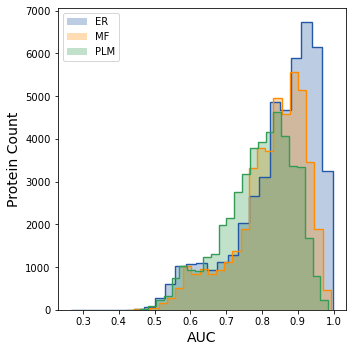

In [4]:
colors_hex = {"red": "#e41a1c", "blue": "#2258A5", "green": "#349C55", "purple": "#984ea3", "orange": "#FF8B00",
                      "yellow": "#ffff33", "grey": "#BBBBBB"}
colors_key = ["blue", "orange", "green"]



# bin AUC values for each method
plt.figure(figsize=(5.,5.))


for i, method_auc in enumerate(method_aucs):
    method = method_label[i]
    plt.hist(method_auc, bins=25, alpha=.3, label = method, color=colors_hex[colors_key[i]])  # density=False would make counts
    plt.hist(method_auc, bins=25, histtype='step', color=colors_hex[colors_key[i]], linewidth=1.4)  # density=False would make counts

plt.legend()
plt.ylabel('Protein Count', fontsize=14)
plt.xlabel('AUC', fontsize=14)
plt.tight_layout()
plt.savefig('method_AUC_hist')
plt.show()


# Which Method is Best
* make a dataframe for it

46827


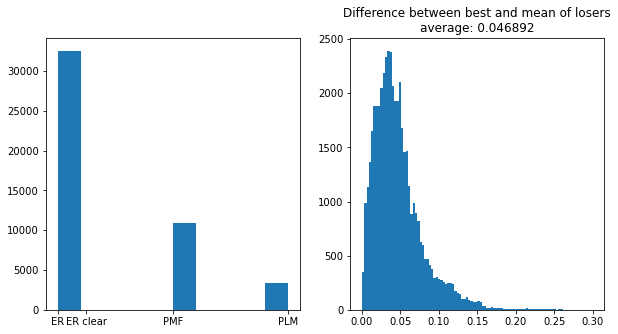

In [5]:
# plot best Method
max_auc_indices = []
max_aucs = []
auc_differences = []
print(len(method_aucs[0]))
for i, er_auc in enumerate(method_aucs[0]):
    pmf_auc = method_aucs[1][i]
    plm_auc = method_aucs[2][i]
    auc_compare = [er_auc, pmf_auc, plm_auc]
    max_auc = max(auc_compare)
    max_aucs.append(max_auc)
    max_auc_index = auc_compare.index(max_auc)
    max_auc_indices.append(max_auc_index)
    auc_differences.append(abs(max_auc - np.mean([auc for auc in auc_compare if auc!=max_auc])))
    
    if bootstrapping:
        # confidence intervals
        alpha = 0.95
        p = ((1.0-alpha)/2.0) * 100
        lower = max(0.0, np.percentile(ER_bootstrap_aucs[i], p))
        p = (alpha+((1.0-alpha)/2.0)) * 100
        upper = min(1.0, np.percentile(ER_bootstrap_aucs[i], p))
        #print('ER auc =%f PLM auc=%f PMF auc=%f\n%.1f confidence interval %.1f%% and %.1f%%' % 
        #      (er_auc, plm_auc, pmf_auc, alpha*100, lower*100, upper*100))
        if max_auc_index == 0 and np.mean([auc for auc in auc_compare if auc!=max_auc]) < lower:
            max_auc_indices.append(.25)


plt.figure(figsize=(10.0,5.))
ax = plt.subplot2grid((1,2),(0,0))
ax.hist(max_auc_indices ,range=(0,2) )  # density=False would make counts

ax.set_xticks([0,.25,1,2])
ax.set_xticklabels(['ER', 'ER clear', 'PMF', 'PLM'])
plt.subplot2grid((1,2), (0,1))
plt.hist(auc_differences, bins = 100, range=(0,.3))  # density=False would make counts
plt.title('Difference between best and mean of losers\naverage: %f' % np.mean(auc_differences))
plt.show()




# Binning By Column Length

;46827, 46827, 46827
[(11.0, 74.55555555555556), (74.55555555555556, 138.11111111111111), (138.11111111111111, 201.66666666666669), (201.66666666666669, 265.22222222222223), (265.22222222222223, 328.77777777777777), (328.77777777777777, 392.33333333333337), (392.33333333333337, 455.8888888888889), (455.8888888888889, 519.4444444444445), (519.4444444444445, 583.0)]


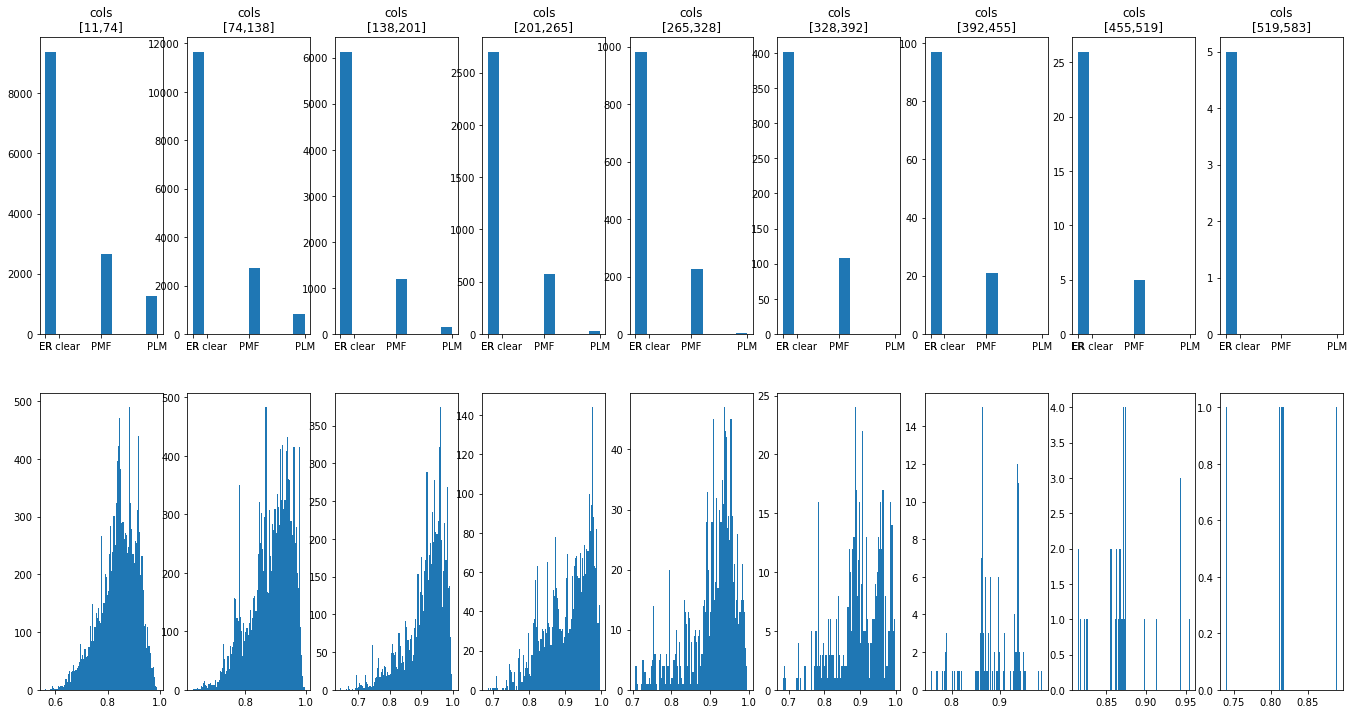

In [6]:
def bin_by(aucs, max_aucs, shapes, metric_label='cols', n_bins=5):
    n_bins = 10
    
    # set up bins
    binned_auc = []
    binned_method = []
    binned_range = []
    for i in range(n_bins):
        binned_auc.append([])
        binned_method.append([])

    # clear values with not enough sequences.
    bad_indices = []
    for i, msa_shape in enumerate(shapes):
        if msa_shape[0] < 300:
            # print('%d seqs not enough' % msa_shape[0])
            bad_indices.append(i)
    bad_indices = sorted(bad_indices, reverse=True)
    for idx in bad_indices:
        if idx < len(shapes):
            shapes.pop(idx)
            aucs.pop(idx)
            max_aucs.pop(idx)
            
    # set up metric
    if metric_label=='cols':
        metric = [msa_shape[1] for msa_shape in shapes]
    elif metric_label=='num_seq':
        metric = [msa_shape[0] for msa_shape in shapes]
    

    # bin metric values
    if metric_label=='cols':
        bins = np.linspace(min(metric), max(metric), num=n_bins)
    elif metric_label=='num_seq':
        print(min(metric), max(metric))
        bins = np.geomspace(min(metric), max(metric), num=n_bins)

    for i, auc in enumerate(aucs):
        for j, (lower, upper) in enumerate(zip(bins, bins[1:])):
            if i==0:
                binned_range.append((lower,upper))
            if metric[i] >= lower and metric[i] <= upper:
                binned_auc[j].append(auc)
                binned_method[j].append(max_aucs[i])
    return binned_auc, binned_method, binned_range



print(';%d, %d, %d' % (len(max_aucs), len(max_auc_indices), len(MSA_sizes)))
binned_auc, binned_method, binned_range = bin_by(max_aucs, max_auc_indices, MSA_sizes, metric_label='cols', n_bins=5)  
print(binned_range)

plt.figure(figsize=(26.0,12))
for i, auc_bin in enumerate(binned_auc[:-1]):
    method_bin = binned_method[i]
    
    ax = plt.subplot2grid((2,len(binned_auc)), (0,i))
    ax.hist(method_bin ,range=(0,2) )  # density=False would make counts
    ax.set_xticks([0,.25,1,2])
    ax.set_xticklabels(['ER', 'ER clear', 'PMF', 'PLM'])
    ax.set_title('%s\n[%d,%d]' %('cols', binned_range[i][0], binned_range[i][1]))
    plt.subplot2grid((2,len(binned_auc)),(1,i))
    plt.hist(auc_bin, bins = 100)  # density=False would make counts
plt.show()

300 115689
[(300.0, 581.3980451635373), (581.3980451635373, 1126.745623066608), (1126.745623066608, 2183.6256754916603), (2183.6256754916603, 4231.852330332527), (4231.852330332527, 8201.30224092031), (8201.30224092031, 15894.07030222136), (15894.07030222136, 30802.604678011063), (30802.604678011063, 59695.24715246945), (59695.24715246945, 115689.0)]


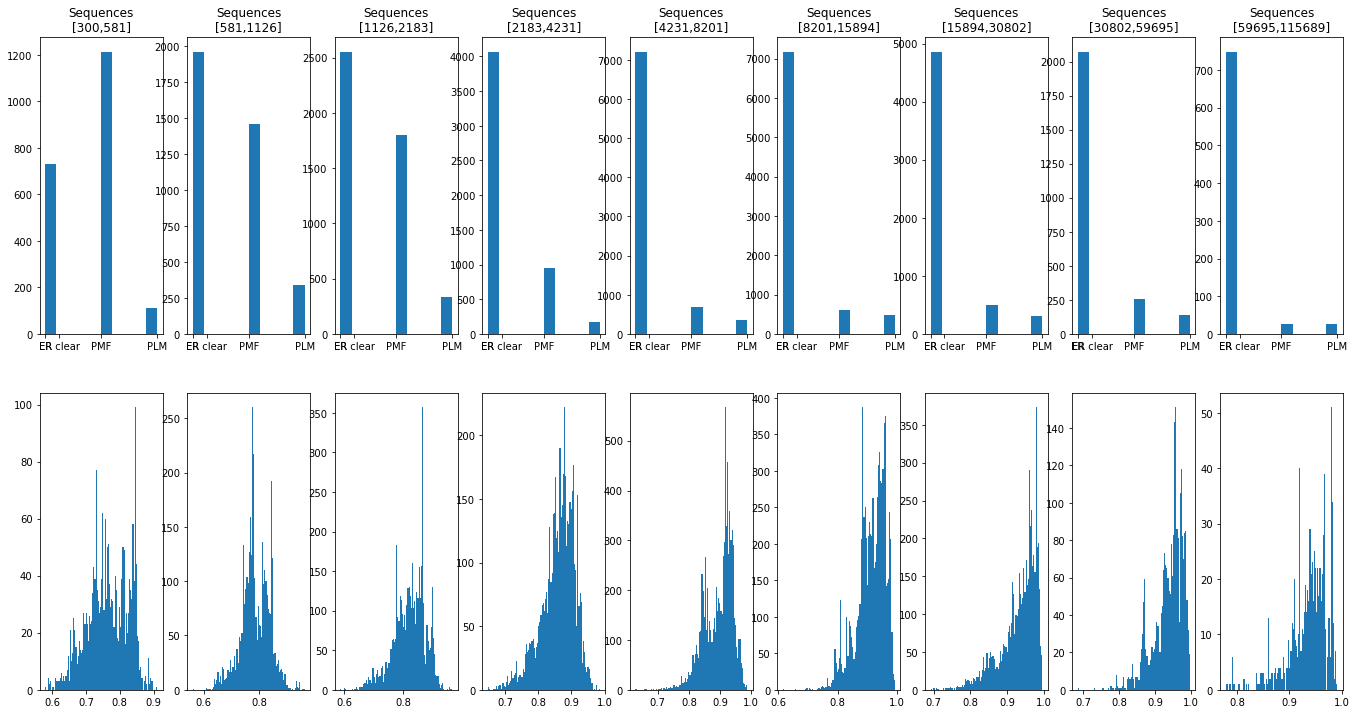

In [7]:
    
binned_auc, binned_method, binned_range = bin_by(max_aucs, max_auc_indices, MSA_sizes, metric_label='num_seq', n_bins=5)  
print(binned_range)

plt.figure(figsize=(26.0,12))
for i, auc_bin in enumerate(binned_auc[:-1]):
    method_bin = binned_method[i]
    
    ax = plt.subplot2grid((2,len(binned_auc)), (0,i))
    ax.hist(method_bin ,range=(0,2) )  # density=False would make counts
    ax.set_xticks([0,.25,1,2])
    ax.set_xticklabels(['ER', 'ER clear', 'PMF', 'PLM'])
    ax.set_title('%s\n[%d,%d]' %('Sequences', binned_range[i][0], binned_range[i][1]))
    plt.subplot2grid((2,len(binned_auc)),(1,i))
    plt.hist(auc_bin, bins = 100)  # density=False would make counts
plt.show()

In [8]:
import pandas as pd
import seaborn as sns
def gen_auc_df(aucs, max_aucs, shapes, pdb_ids, pfam_ids):
    cols = [msa_shape[1] for msa_shape in shapes]
    seqs = [msa_shape[0] for msa_shape in shapes]
    best_method = []
    for x in max_aucs:
        if x==0:
            best_method.append('ER')
        elif x==1:
            best_method.append('PMF')
        elif x==2:
            best_method.append('PLM')
    zipped = list(zip(aucs, best_method, seqs, effective_seqs, cols, pdb_ids, pfam_ids))
    df_labels = ['AUC', 'Best Method', '# Sequences', 'Effective Sequence #', '# Positions', 'PDB ID', 'Pfam ID']
    df = pd.DataFrame(zipped, columns=df_labels)
    return df

auc_df = gen_auc_df(max_aucs, max_auc_indices, MSA_sizes, pdb_ids, pfam_ids)



In [9]:
print(auc_df[auc_df.AUC==auc_df.AUC.max()])
print(auc_df.loc[auc_df['PDB ID'] == '1zdr'])

            AUC Best Method  # Sequences  Effective Sequence #  # Positions  \
9473   0.996954          ER        44082          16763.501173          143   
29227  0.996954          ER        44082            370.562961          143   

      PDB ID  Pfam ID  
9473    3qmx  PF00462  
29227   7awr  PF05409  
            AUC Best Method  # Sequences  Effective Sequence #  # Positions  \
29717  0.848645          ER        21892          14740.648773           64   

      PDB ID  Pfam ID  
29717   1zdr  PF00186  


In [10]:
from joblib import Parallel, delayed
def get_tp_val(fp_val, fpr, tpr):
    for i, fp in enumerate(fpr):
        if fp < fp_val:
            continue
        elif fp == fp_val:
            return tpr[i]
        elif tpr[i] == tpr[i-1]:
            return tpr[i]
        if i > 0:
            d = np.sqrt(abs(fp - fpr[i-1])**2 + abs(tpr[i]-tpr[i-1])**2)
            avg_p = abs(fp_val-fpr[i-1])/d
            tp_val = tpr[i-1] + avg_p * abs(tpr[i]-tpr[i-1])
        else:
            d = np.sqrt(abs(fp - 0)**2 + abs(tpr[i]-0)**2)
            avg_p = fp_val/d
            tp_val = avg_p * tpr[i]
        return tp_val

def get_full_length_tpr(fprs, tprs, full_fpr, i):
    tpr = [get_tp_val(fp_val, fprs[i], tprs[i]) for fp_val in full_fpr]
    print('%d tpr full: ' % i,  len(tpr))
    return tpr

def get_average_roc(tprs, fprs):
    average_fpr = fprs[0]
    print(len(average_fpr))
    # fill average fpr with all
    for i, fpr in enumerate(fprs[1:]):
        average_fpr = np.unique(np.sort(np.concatenate((average_fpr, fpr))))
    print(len(average_fpr))

    average_tpr = np.zeros(len(average_fpr))
    tprs_full = Parallel(n_jobs = 14)(delayed(get_full_length_tpr)(fprs, tprs, average_fpr, i) for i in range(len(fprs)))
    for i, fpr in enumerate(fprs):
        average_tpr = np.add(np.array(tprs_full[i]), average_tpr)
        #plt.plot(fprs[i], tprs[i])
    average_tpr = average_tpr / len(fprs)
    #plt.plot(average_fpr, average_tpr, lw=2.5)
    return average_fpr, average_tpr, tprs_full


# KS Comparison

In [11]:
# plot best Method
from itertools import combinations
method_ids = ['ER', 'PMF', 'PLM']

method_combos =['%svs%s' % combo for combo in combinations(method_ids, 2)]
ks_vals = {}
p_vals = {}

# asymptotic ks test, and z test run_from method_comparison.py
ks_vals_asympt = {}
p_vals_asympt = {}
z = {}
print(mc[0].keys())
for ks_combo in mc[0].keys():
    ks_vals[ks_combo] = []
    p_vals[ks_combo] = []
    ks_vals_asympt[ks_combo] = []
    p_vals_asympt[ks_combo] = []
    z[ks_combo] = []

ER_combos = [combo for combo in method_combos if "ER" in combo]
PLM_combos = [combo for combo in method_combos if "PLM" in combo]
PMF_combos = [combo for combo in method_combos if "MF" in combo]
ks_max = .2

max_auc_indices = []
max_aucs = []
auc_differences = []
for i, er_auc in enumerate(method_aucs[0]):
    pmf_auc = method_aucs[1][i]
    plm_auc = method_aucs[2][i]
    auc_compare = [er_auc, pmf_auc, plm_auc]
    max_auc = max(auc_compare)
    max_aucs.append(max_auc)
    max_auc_index = auc_compare.index(max_auc)
    max_auc_indices.append(max_auc_index)
    auc_differences.append(abs(max_auc - np.mean([auc for auc in auc_compare if auc!=max_auc])))
    try: # during swarm simulations theres an issue with PMF vs MF keys.. should distiguish PYDCA MF (PMF)
        ks = mc[i]
        for ks_combo in ks.keys():
            try:
                ks_vals[ks_combo].append(ks[ks_combo][0])
                p_vals[ks_combo].append(ks[ks_combo][1])
                ks_vals_asympt[ks_combo].append(mc[i][ks_combo][0][0])
                p_vals_asympt[ks_combo].append(mc[i][ks_combo][0][1])

                z[ks_combo].append(mc[j][ks_combo][1][0][0])
            except(IndexError):
                continue



        if bootstrapping:
            # confidence intervals
            alpha = 0.95
            p = ((1.0-alpha)/2.0) * 100
            lower = max(0.0, np.percentile(ER_bootstrap_aucs[i], p))
            p = (alpha+((1.0-alpha)/2.0)) * 100
            upper = min(1.0, np.percentile(ER_bootstrap_aucs[i], p))
            #print('ER auc =%f PLM auc=%f PMF auc=%f\n%.1f confidence interval %.1f%% and %.1f%%' % 
            #      (er_auc, plm_auc, pmf_auc, alpha*100, lower*100, upper*100))

        if max_auc_index == 0 and np.mean([ks[combo][0] for combo in ER_combos]) <= ks_max:
            max_auc_indices.append(.25)
        if max_auc_index == 1 and np.mean([ks[combo][0] for combo in PMF_combos]) <= ks_max:
            max_auc_indices.append(1.25)
        if max_auc_index == 2 and np.mean([ks[combo][0] for combo in PLM_combos]) <= ks_max:
            max_auc_indices.append(2.25)
    except(KeyError):
        continue
# print(ks_vals)
# print(z)

dict_keys(['ERvsPMF', 'ERvsPLM', 'PMFvsPLM'])


In [12]:
if 0: # takes a long time. ks-asymptotic is better anyways
    plt.figure(figsize=(15.0,5.))
    ax1=plt.subplot2grid((3,1), (0,0), colspan=1, rowspan=1)
    ax2=plt.subplot2grid((3,1), (1,0), colspan=1, rowspan=1)
    ax3=plt.subplot2grid((3,1), (2,0), colspan=1, rowspan=1)


    for ks_combo in mc[0].keys():
        ax1.hist(ks_vals[ks_combo], bins=25, alpha=.3, label =ks_combo)  # density=False would make counts
        ax1.hist(ks_vals[ks_combo], bins=25, histtype='step', linewidth=1.4)  # density=False would make counts

        ax2.hist(p_vals[ks_combo], bins=100, alpha=.3, label =ks_combo)  # density=False would make counts
        ax2.hist(p_vals[ks_combo], bins=100, histtype='step', color='k', linewidth=1.4)  # density=False would make counts

    ax1.legend()
    ax2.legend()
    ax1.set_title('KS statistic', fontsize = 14)
    ax2.set_title('p-values', fontsize=14)

    ax3.hist(max_auc_indices ,range=(0,2.5) )  # density=False would make counts
    ax3.set_xticks([0,.25,1,1.25,2,2.25])
    ax3.set_xticklabels(['ER', 'ER clear ks' , 'PMF', 'PMF clear ks', 'PLM', 'PLM clear ks'])
    ax3.set_title('Method win count vs KS <.2 Method win count', fontsize=35)
    #plt.setp(ax1.get_xticklabels(),fontsize=25)
    #plt.setp(ax1.get_yticklabels(),fontsize=25)
    #plt.setp(ax2.get_xticklabels(),fontsize=25)
    #plt.setp(ax2.get_yticklabels(),fontsize=25)
    #plt.setp(ax3.get_xticklabels(),fontsize=25)
    ##plt.setp(ax3.get_yticklabels(),fontsize=25)
    plt.savefig('ks_comparison.pdf')
    plt.show()

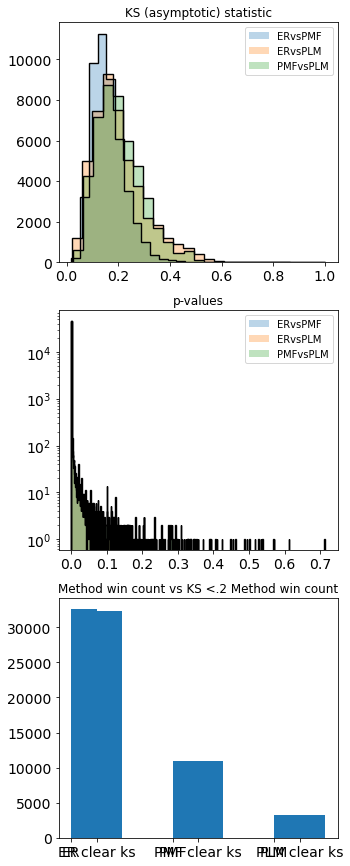

46827
46827
46818
46827
46827
46818


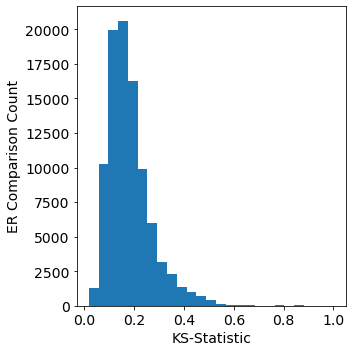

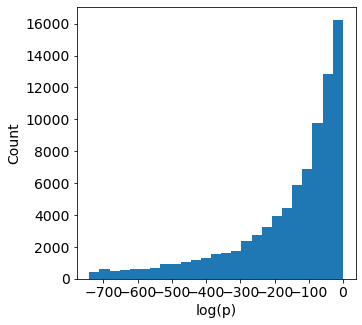

In [13]:
# asymptotic ks
plt.figure(figsize=(5.,15.))
ax1=plt.subplot2grid((3,1), (0,0), colspan=1, rowspan=1)
ax2=plt.subplot2grid((3,1), (1,0), colspan=1, rowspan=1)
ax3=plt.subplot2grid((3,1), (2,0), colspan=1, rowspan=1)


        
for ks_combo in mc[0].keys():
    ax1.hist(ks_vals_asympt[ks_combo], bins=25, alpha=.3, label =ks_combo, )  # density=False would make counts
    ax1.hist(ks_vals_asympt[ks_combo], bins=25, histtype='step', color='k', linewidth=1.4)  # density=False would make counts

    ax2.hist(p_vals_asympt[ks_combo], log=True, bins=500, alpha=.3, label =ks_combo, linewidth=1.4)  # density=False would make counts
    ax2.hist(p_vals_asympt[ks_combo], log=True, bins=500, histtype='step', color='k', linewidth=1.4)  # density=False would make counts

ax1.legend()
ax2.legend()
ax1.set_title('KS (asymptotic) statistic')
ax2.set_title('p-values')

ax3.hist(max_auc_indices ,range=(0,2.5) )  # density=False would make counts
ax3.set_xticks([0,.25,1,1.25,2,2.25])
ax3.set_xticklabels(['ER', 'ER clear ks' , 'PMF', 'PMF clear ks', 'PLM', 'PLM clear ks'])
ax3.set_title('Method win count vs KS <.2 Method win count')
plt.setp(ax1.get_xticklabels(),fontsize=14)
plt.setp(ax1.get_yticklabels(),fontsize=14)
plt.setp(ax2.get_xticklabels(),fontsize=14)
plt.setp(ax2.get_yticklabels(),fontsize=14)
plt.setp(ax3.get_xticklabels(),fontsize=14)
plt.setp(ax3.get_yticklabels(),fontsize=14)
plt.savefig('ks_asympt_comparison.pdf')
plt.show()

# Manuscript KS- plots
ER_ks_vals = []
for ks_combo in mc[0].keys():
    print(len(ks_vals_asympt[ks_combo]))
    if 'ER' in ks_combo:
        ER_ks_vals.extend(ks_vals_asympt[ks_combo])
ER_ks_pvals = []
for ks_combo in mc[0].keys():
    print(len(p_vals_asympt[ks_combo]))
    if 'ER' in ks_combo:
        temp = []
        for p in p_vals_asympt[ks_combo]:
            if p!=0:
                temp.append(np.log(p))
        ER_ks_pvals.extend(temp)
plt.figure(figsize=(5.,5.))
ax1=plt.subplot2grid((1,1), (0,0), colspan=1, rowspan=1)
ax1.hist(ER_ks_vals, bins=25)  # density=False would make counts
plt.setp(ax1.get_xticklabels(),fontsize=14)
plt.setp(ax1.get_yticklabels(),fontsize=14)
ax1.set_xlabel('KS-Statistic', fontsize=14)
ax1.set_ylabel('ER Comparison Count', fontsize=14)
plt.tight_layout()
plt.savefig('ER_ks_hist.pdf')
plt.show()

plt.figure(figsize=(5.,5.))
ax1=plt.subplot2grid((1,1), (0,0), colspan=1, rowspan=1)
ax1.hist(ER_ks_pvals, bins=25)  # density=False would make counts
ax1.set_xlabel('log(p)', fontsize=14)
ax1.set_ylabel('Count', fontsize=14)
plt.setp(ax1.get_xticklabels(),fontsize=14)

plt.setp(ax1.get_yticklabels(),fontsize=14)
plt.savefig('ER_kspval_hist.pdf')
plt.show()


# Z-test Comparison

In [14]:
if 0:
    # plot best Method
    z_lower = -2
    for ks_combo in ks.keys():
        print(len(z[ks_combo]))
    max_auc_indices_z = []
    for i, er_auc in enumerate(method_aucs[0]):
        pmf_auc = method_aucs[1][i]
        plm_auc = method_aucs[2][i]
        auc_compare = [er_auc, pmf_auc, plm_auc]
        max_auc = max(auc_compare)
        max_auc_index = auc_compare.index(max_auc)
        max_auc_indices_z.append(max_auc_index)


        if max_auc_index == 0 and np.mean([z[ks_combo] for ks_combo in ks.keys() if '_MF' not in ks_combo and 'ER' in ks_combo]) < z_lower:
            max_auc_indices_z.append(.25)
        if max_auc_index == 1 and np.mean([z[ks_combo] for ks_combo in ks.keys() if '_MF' not in ks_combo and 'PMF' in ks_combo]) < z_lower:
            max_auc_indices_z.append(1.25)
        if max_auc_index == 2 and np.mean([z[ks_combo] for ks_combo in ks.keys() if '_MF' not in ks_combo and 'PLM' in ks_combo]) < z_lower:
            max_auc_indices_z.append(2.25)

    print('ER has %d clear winners' % len([val for val in max_auc_indices_z if val == .25]))
    print('PMF has %d clear winners' % len([val for val in max_auc_indices_z if val == 1.25]))
    print('PLM has %d clear winners' % len([val for val in max_auc_indices_z if val == 2.25]))


In [15]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
dark2 = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=0, vmax=len(mc[0].keys()))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=dark2)
# asymptotic ks
if 0:
    # z-test comparison
    plt.figure(figsize=(36.0,26))
    ax1=plt.subplot2grid((2,1), (0,0), colspan=1, rowspan=1)


    for i, ks_combo in enumerate(mc[0].keys()):
        if i == 0:
            _, bins,_ = ax1.hist(z[ks_combo], bins=150, alpha=.2, color=scalarMap.to_rgba(i))  # density=False would make counts
            ax1.hist(z[ks_combo], bins=bins, histtype='step', color=scalarMap.to_rgba(i), linewidth=2, label =ks_combo, )  # density=False would make counts
        else:
            ax1.hist(z[ks_combo], bins=bins, alpha=.2, color=scalarMap.to_rgba(i) )  # density=False would make counts
            ax1.hist(z[ks_combo], bins=bins, histtype='step', color=scalarMap.to_rgba(i), linewidth=2, label =ks_combo, )  # density=False would make counts




    ax1.legend(fontsize=25)
    ax1.set_title('Z-test Comparison', fontsize = 35)

    plt.setp(ax1.get_xticklabels(),fontsize=25)
    plt.setp(ax1.get_yticklabels(),fontsize=25)

    ax1.set_xlim((-15,0))

    ax3=plt.subplot2grid((2,1), (1,0), colspan=1, rowspan=1)


    ax3.hist(max_auc_indices_z ,range=(0,2.5) )  # density=False would make counts
    ax3.set_xticks([0,.25,1,1.25,2,2.25])
    ax3.set_xticklabels(['ER', 'ER clear ks' , 'PMF', 'PMF clear ks', 'PLM', 'PLM clear ks'])
    ax3.set_title('Method win count vs Z-test log(p-value)<%f Method win count' % z_lower, fontsize=35)

    plt.setp(ax3.get_xticklabels(),fontsize=25)
    plt.setp(ax3.get_yticklabels(),fontsize=25)
    plt.savefig('z_comparison.pdf')
plt.show()

In [16]:
import pandas as pd
import seaborn as sns
ks_max = .2
c_alpha = {.2:1.073, .14:1.138, .1:1.224, .05:1.358, .025:1.48, .01:1.628, .005:1.731, .001:1.949}
alpha = .001
from scipy.special import comb
combos = [[combo for combo in method_combos if "ER" in combo], [combo for combo in method_combos if "PLM" in combo]
          ,[combo for combo in method_combos if "PMF" in combo]]
print(len(ks_vals_asympt['ERvsPMF']))
n_cols_full = []
n_seqs_full = []
methods_full = []
pdb_ids_full = []
pfam_ids_full = []
aucs_full = []
neffs_full = []
best_method_full = []
auc_differences_full = []
ks_clear_full = []
for i, method_auc_data in enumerate(method_aucs):
    ks_crit = c_alpha[alpha] * np.sqrt(2*comb(n_cols[i],2) / comb(n_cols[i],2)**2)

    for j, auc in enumerate(method_auc_data):
        pdb_ids_full.append(pdb_ids[j])
        pfam_ids_full.append(pfam_ids[j])
        methods_full.append(method_label[i])
        aucs_full.append(auc)
        n_cols_full.append(n_cols[j])
        n_seqs_full.append(n_seqs[j])
        neffs_full.append(effective_seqs[j])
        

        # Best method
        er_auc = method_aucs[0][j]
        pmf_auc = method_aucs[1][j]
        plm_auc = method_aucs[2][j]
        auc_compare = [er_auc, pmf_auc, plm_auc]
        max_auc = max(auc_compare)
        max_aucs.append(max_auc)
        max_auc_index = auc_compare.index(max_auc)
        if max_auc_index == 0:
            best_method_full.append('ER')
        elif max_auc_index == 1: 
            best_method_full.append('MF')
        else:            
            best_method_full.append('PLM')
        
        auc_differences_full.append(abs(max_auc - np.mean([auc for auc in auc_compare if auc!=max_auc])))

        # KS
        ks = mc[i]
        try:
            if max_auc_index == 0 and np.mean([ks_vals_asympt[combo][j] for combo in combos[0]]) >= ks_crit:
                ks_clear_full.append(True)
            elif max_auc_index == 1 and np.mean([ks_vals_asympt[combo][j] for combo in combos[1]]) >= ks_crit:
                ks_clear_full.append(True)
            elif max_auc_index == 2 and np.mean([ks_vals_asympt[combo][j] for combo in combos[2]]) >= ks_crit:
                ks_clear_full.append(True)
            else:
                ks_clear_full.append(False)
        except(IndexError):
            print(j)
method_comparison_df = pd.DataFrame(list(zip(n_cols_full, n_seqs_full, neffs_full, methods_full, best_method_full, pdb_ids_full, pfam_ids_full, aucs_full, ks_clear_full)),
               columns =['Number of Columns', 'Number of Sequences', 'Effective Sequences', 'Method', 'Best Method', 'PDB ID', 'Pfam ID', 'AUC', 'KS-Mean Clear'])
        
# Stratify by Number of Columns
method_comparison_df['Column Number Range'] = pd.cut(method_comparison_df['Number of Columns'],np.arange(min(method_comparison_df['Number of Columns']),max(method_comparison_df['Number of Columns']),step=200))

# Stratify by Number of Sequences
method_comparison_df['Sequence Number Range'] = pd.cut(method_comparison_df['Number of Sequences'],np.arange(min(method_comparison_df['Number of Sequences']),max(method_comparison_df['Number of Sequences']),step=10000))

# Remove all proteins with less than 300 Sequences
method_comparison_df = method_comparison_df.loc[method_comparison_df['Effective Sequences']  >= 150]

# Stratify by Number of Sequences (log scale)
log_min =np.log10(min(method_comparison_df['Effective Sequences']))
log_max =np.log10(max(method_comparison_df['Effective Sequences']))
print(log_min, log_max)

log_ranges = np.linspace(log_min,log_max,num=4)
method_comparison_df['Effective Sequences (log)'] = pd.cut(np.log10(method_comparison_df['Effective Sequences']),log_ranges)



print( method_comparison_df.head())
print(method_comparison_df.loc[method_comparison_df['PDB ID'] == '1zdr'])



46827
46820
46821
46822
46820
46821
46822
46820
46821
46822
2.176200497848028 4.912902533361897
   Number of Columns  Number of Sequences  Effective Sequences Method  \
0               97.0               5787.0          3564.110210     ER   
1              206.0               3492.0          1202.800115     ER   
2              177.0              27623.0         15196.688260     ER   
3              199.0              29512.0         21471.492280     ER   
4               79.0               2749.0           800.471393     ER   

  Best Method PDB ID  Pfam ID       AUC  KS-Mean Clear Column Number Range  \
0          ER   3au8  PF02670  0.909199           True        (5.0, 205.0]   
1          MF   1ivv  PF01179  0.868621           True      (205.0, 405.0]   
2          ER   2qxi  PF00089  0.985399           True        (5.0, 205.0]   
3          ER   1pwd  PF00144  0.983466           True        (5.0, 205.0]   
4          MF   5e4g  PF00019  0.814122           True        (5.0, 205.0] 

In [17]:
df_unique_results = method_comparison_df.loc[method_comparison_df['Method'] == method_comparison_df['Best Method']]
len(df_unique_results)
print('ks mean clear proteins: ',len(df_unique_results.loc[df_unique_results['KS-Mean Clear']==True]))
print('non-clear proteins: ',len(df_unique_results.loc[df_unique_results['KS-Mean Clear']==False]))

ks mean clear proteins:  40968
non-clear proteins:  5


## Bin AUC 

  Best Method  KS-Mean Clear  Method
0          ER           True   31309
1          ER          False       5
2          MF           True    7314
3         PLM           True    2345


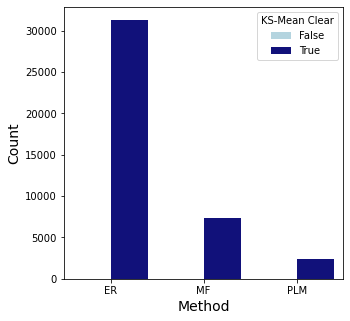

df_method_count: 
 Method  Method
ER      ER        31314
MF      MF         7314
PLM     PLM        2345
Name: Method, dtype: int64


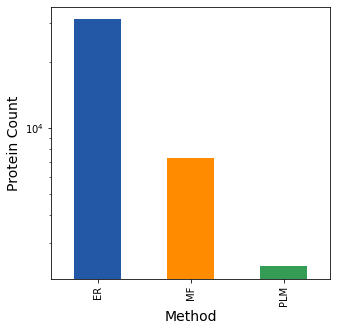

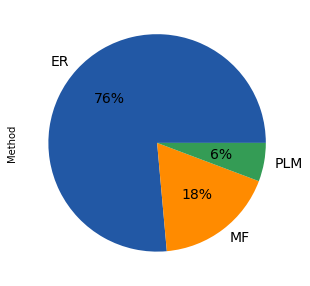

In [18]:
import matplotlib.patches as mpatches
#set seaborn plotting aesthetics

# # bin AUC values for each method
# plt.figure(figsize=(5.0,5.))
# ax = plt.subplot2grid((1,1),(0,0))

x,y,hue = 'KS-Mean Clear', 'Method','Best Method'
df_best_method_count= (df_unique_results [x].groupby(df_unique_results [hue]).value_counts().rename(y).reset_index())
df_best_method_count = df_best_method_count.rename(columns={"level_1":x})
print(df_best_method_count)
#create stacked bar chart
#df_best_method_count.set_index('Best Method').plot(kind='bar', stacked=True)

# set plot style: grey grid in the background:
#sns.set(style="darkgrid")

# set the figure size
plt.figure(figsize=(5., 5.))
ax = plt.subplot2grid((1,1),(0,0))
sns.barplot(x="Best Method", y="Method",  hue="KS-Mean Clear", data=df_best_method_count, palette=['lightblue', 'darkblue'], ax=ax)

# # top bar -> sum all values(smoker=No and smoker=Yes) to find y position of the bars
# total = df_unique_results.groupby('Method')['KS-Mean Clear'].sum().reset_index()
# # bar chart 1 -> top bars (group of total group)
# print(total)
# bar1 = sns.barplot(x="Method",  y="KS-Mean Clear", data=total, color='lightblue', ax=ax)
# # bottom bar ->  take only KS-Mean Clear values from the data
# ks_clear = df_unique_results.loc[df_unique_results['KS-Mean Clear']==True]
# print(len(ks_clear))
# total_clear = ks_clear.groupby('Method')['KS-Mean Clear'].sum().reset_index()
# print(total_clear)
# # bar chart 2 -> bottom bars (group of 'KS-Mean Clear')
# bar2 = sns.barplot(x="Method", y="KS-Mean Clear", data=total_clear,estimator=sum, ci=None,  color='darkblue', ax=ax)

# # add legend
# top_bar = mpatches.Patch(color='lightblue', label='Not a Clear Winner (KS-Mean)')
# bottom_bar = mpatches.Patch(color='darkblue', label='Clear Winner (KS-Mean)')
ax.set_ylabel('Count', fontsize = 14)
ax.set_xlabel('Method', fontsize = 14)

plt.legend(title='KS-Mean Clear')
plt.savefig('BM_ksclear.pdf')
plt.show()


# Create Bars for Log scale Sequence Number ranges.
x,y,hue = 'Method', 'Method','Best Method'
df_method_count= (df_unique_results [x].groupby(df_unique_results [x]).value_counts())
print("df_method_count: \n", df_method_count)


# bin AUC values for each method
plt.figure(figsize=(5.0,5.))
ax = plt.subplot2grid((1,1),(0,0))

g1 = df_unique_results[x].value_counts().plot(kind='bar',
                                        ax = ax,
                                         color=["#2258A5", "#FF8B00","#349C55"])
# g1 = sns.barplot(x=x, data=df_method_count,ax=ax, palette = ["#2258A5", "#FF8B00","#349C55"])
g1.set_yscale('log')
ax.set_ylabel('Protein Count', fontsize=14)
ax.set_xlabel(x, fontsize=14)

plt.savefig('BM_count.pdf')


plt.figure(figsize=(5.0,5.))
ax = plt.subplot2grid((1,1),(0,0))
g1 = df_unique_results[x].value_counts().plot(kind='pie', autopct='%1.0f%%',fontsize=14,colors=["#2258A5", "#FF8B00","#349C55"])
# g1 = sns.barplot(x=x, data=df_method_count,ax=ax, palette = ["#2258A5", "#FF8B00","#349C55"])

plt.savefig('BM_count_pie.pdf')

### Bin AUC (stratify by Number of Sequences)

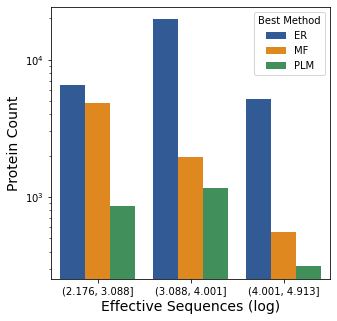

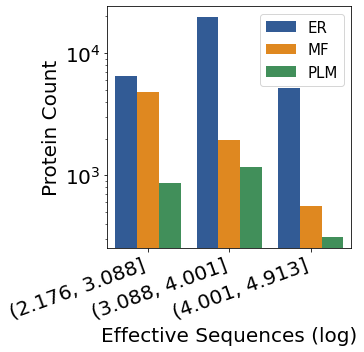

In [19]:
# Create Bars for Log scale Sequence Number ranges.
x,y,hue = 'Effective Sequences (log)', 'Method','Best Method'
df_seq_range_count= (df_unique_results [x].groupby(df_unique_results [hue]).value_counts().rename(y).reset_index())
df_seq_range_count = df_seq_range_count.rename(columns={"level_1":x})
num_seq_order = df_seq_range_count.loc[df_seq_range_count['Method']>10][x].sort_values().unique()


# bin AUC values for each method
plt.figure(figsize=(5.0,5.))
ax = plt.subplot2grid((1,1),(0,0))

g = sns.barplot(x=x, y=y, hue=hue,order = num_seq_order, data=df_seq_range_count,ax=ax, palette = ["#2258A5", "#FF8B00","#349C55"])
g.set_yscale('log')
ax.set_ylabel('Protein Count', fontsize=14)
ax.set_xlabel(x, fontsize=14)
plt.savefig('BMhist_nseq_logrange.pdf')

plt.show()

# Create Bars for Log scale Sequence Number ranges.
x,y,hue = 'Effective Sequences (log)', 'Method','Best Method'
df_seq_range_count= (df_unique_results [x].groupby(df_unique_results [hue]).value_counts().rename(y).reset_index())
df_seq_range_count = df_seq_range_count.rename(columns={"level_1":x})
num_seq_order = df_seq_range_count.loc[df_seq_range_count['Method']>10][x].sort_values().unique()


# bin AUC values for each method
plt.figure(figsize=(5.0,5.))
ax = plt.subplot2grid((1,1),(0,0))
g1 = sns.barplot(x=x, y=y, hue=hue,order = num_seq_order, data=df_seq_range_count,ax=ax, palette = ["#2258A5", "#FF8B00","#349C55"])
ax.set_ylabel('Protein Count', fontsize=20)
ax.set_xlabel(x, fontsize=20)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, rotation=20, ha='right')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
g1.set_yscale('log')
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('BMhist_nseq_logrange_poster.pdf')
plt.show()

### Bin AUC (stratify by Number of Columns)

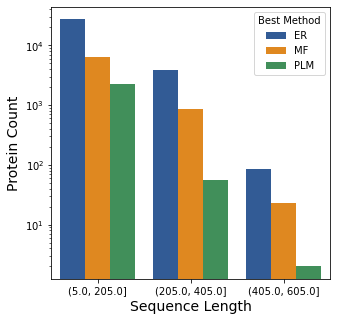

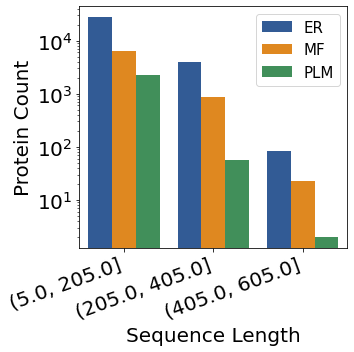

In [20]:
# Create Bars for Log scale Sequence Number ranges.
x,y,hue = 'Column Number Range', 'Method','Best Method'
df_seq_range_count= (df_unique_results [x].groupby(df_unique_results [hue]).value_counts().rename(y).reset_index())
df_seq_range_count = df_seq_range_count.rename(columns={"level_1":x})
num_seq_order = df_seq_range_count.loc[df_seq_range_count['Method']>10][x].sort_values().unique()


# bin AUC values for each method
plt.figure(figsize=(5.0,5.))
ax = plt.subplot2grid((1,1),(0,0))

gc = sns.barplot(x=x, y=y, hue=hue,order = num_seq_order, data=df_seq_range_count,ax=ax, palette = ["#2258A5", "#FF8B00","#349C55"])
gc.set_yscale('log')
ax.set_ylabel('Protein Count', fontsize=14)
ax.set_xlabel('Sequence Length', fontsize=14)
plt.savefig('BMhist_ncol_range.pdf')

plt.show()
# bin AUC values for each method
plt.figure(figsize=(5.0,5.))
ax = plt.subplot2grid((1,1),(0,0))
gc = sns.barplot(x=x, y=y, hue=hue,order = num_seq_order, data=df_seq_range_count,ax=ax, palette = ["#2258A5", "#FF8B00","#349C55"])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
gc.set_yscale('log')
ax.set_ylabel('Protein Count', fontsize=20)
ax.set_xlabel('Sequence Length', fontsize=20)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, rotation=20, ha='right')
plt.legend(fontsize=15)
plt.tight_layout()

plt.savefig('BMhist_ncol_range_poster.pdf')
plt.show()

In [26]:
# get 100 proteins from each sequence-count range
x,y,hue = 'Effective Sequences (log)', 'Method','Best Method'

ex_pdb_ids = []
ex_pfam_ids = []
ex_aucs = []
ex_nseq = []
# print(df_unique_results.groupby(df_unique_results[x]).head())
print(df_unique_results[x].unique())
for eff_seq_range in df_unique_results[x].unique():
    top100_range = df_unique_results.loc[df_unique_results[x] == eff_seq_range].sort_values('AUC', ascending=False)[:100]
    ex_pdb_ids.extend(top100_range['PDB ID'].values)
    ex_pfam_ids.extend(top100_range['Pfam ID'].values)
    ex_aucs.extend(top100_range['AUC'].values)
    ex_nseq.extend(top100_range['Effective Sequences'].values)

print(len(ex_pdb_ids))
print(len(ex_pfam_ids))
print(len(ex_aucs))
print(len(ex_nseq))

print(ex_pdb_ids[:10])
print(ex_pfam_ids[:10])
print(ex_aucs[:10])
print(ex_nseq[:10])
print(len(np.unique(ex_pfam_ids)))
print(len(np.unique(ex_pdb_ids)))

# write swarm file for individual plots
f = open('single_protein_plots.swarm','w')
for i, pdb_id  in enumerate(ex_pdb_ids):
    pfam_id = ex_pfam_ids[i]
    auc = ex_aucs[i]
    nseq = ex_nseq[i]
    f.write('source /data/cresswellclayec/conda/etc/profile.d/conda.sh; ')
    f.write('conda activate PYDCA; ')
    f.write('python single_protein_plot_pydca.py %s %s %s %s $SLURM_CPUS_PER_TASK\n'%(pdb_id, pfam_id,floor(100*auc),floor(nseq)))
    #f.write('module load singularity; ')
    #f.write('singularity exec -B /data/cresswellclayec/DCA_ER/biowulf/ /data/cresswellclayec/DCA_ER/dca_er.simg python 1main_ER.py %s\n'%(pdb))
f.close()


[(3.088, 4.001], (4.001, 4.913], (2.176, 3.088], NaN]
Categories (3, interval[float64, right]): [(2.176, 3.088] < (3.088, 4.001] < (4.001, 4.913]]
300
300
300
300
['5ii9', '5j4u', '5jai', '4aaj', '1s0e', '5dd9', '5a02', '3zu8', '2zh1', '1aj0']
['PF01303', 'PF02798', 'PF12241', 'PF00697', 'PF01742', 'PF05053', 'PF01408', 'PF00942', 'PF09249', 'PF00809']
[0.9920404118572728, 0.9920381268080453, 0.9920381268080452, 0.9913144517724899, 0.9905501847202097, 0.9903262774802868, 0.9900156051851609, 0.9889407068874684, 0.9887621455359024, 0.9884857426083559]
[9854.085635166011, 9854.085635166011, 9854.085635166011, 9854.085635166011, 9148.235080968707, 9218.367016193868, 9213.799149097109, 9490.736493875467, 8489.752412325586, 9648.606416459792]
248
300


In [27]:
print(df_unique_results.loc[df_unique_results['Pfam ID']=='PF00196'].head())

       Number of Columns  Number of Sequences  Effective Sequences Method  \
31673               70.0              35820.0         15130.659745     ER   
65783               89.0                793.0           298.259934     MF   
93108               96.0                592.0           181.208484     MF   

      Best Method PDB ID  Pfam ID       AUC  KS-Mean Clear  \
31673          ER   1zlj  PF00196  0.918276           True   
65783          MF   1zlk  PF00196  0.755890           True   
93108          MF   2rnj  PF00196  0.732552           True   

      Column Number Range Sequence Number Range Effective Sequences (log)  
31673        (5.0, 205.0]    (30002.0, 40002.0]            (4.001, 4.913]  
65783        (5.0, 205.0]        (2.0, 10002.0]            (2.176, 3.088]  
93108        (5.0, 205.0]        (2.0, 10002.0]            (2.176, 3.088]  
